In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 6: Set up data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/Users/jaeeponde/tai_final_project/rvf_subset_5000/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# If you have validation data:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/Users/jaeeponde/tai_final_project/rvf_subset_5000/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [6]:
import numpy as np
# Load just 10 images manually
x_small = []
y_small = []

train_generator.reset()
for i in range(1):  # 1 batch of 32 images, or set batch_size=10 above
    x_batch, y_batch = next(train_generator)
    x_small.append(x_batch[:10])
    y_small.append(y_batch[:10])

x_small = np.concatenate(x_small)
y_small = np.concatenate(y_small)


In [7]:
import tensorflow as tf

def create_adversarial_pattern(model, image, label, epsilon=0.01):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)
    return adversarial_image


In [11]:
import tensorflow as tf
import numpy as np

def create_adversarial_pattern(model, image, label, epsilon=0.01):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0.0, 1.0)
    return adv_image

# Helper: number of batches per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    
    # Reset the generator at the start of each epoch (if using shuffle=True)
    train_generator.reset()

    for step in tqdm(range(steps_per_epoch), desc=f"Training Epoch {epoch+1}"):
        x_batch, y_batch = next(train_generator)
        
        # Convert to tensor
        x_tensor = tf.convert_to_tensor(x_batch)
        y_tensor = tf.convert_to_tensor(y_batch)

        # Generate only 30 adversarial samples for each batch
        x_adv = create_adversarial_pattern(model, x_tensor[:30], y_tensor[:30])

        # Combine clean + adversarial (only 30 adversarial samples)
        x_combined = tf.concat([x_tensor, x_adv], axis=0)
        y_combined = tf.concat([y_tensor, y_tensor[:30]], axis=0)  # Same labels for clean and adversarial samples

        # Train on the combined batch
        model.train_on_batch(x_combined, y_combined)

    # Validation after each epoch
    val_loss, val_acc = model.evaluate(validation_generator, verbose=1)
    print(f"✅ Validation accuracy after epoch {epoch+1}: {val_acc:.4f}")





Epoch 1/10


Training Epoch 1: 100%|██████████| 93/93 [36:19<00:00, 23.43s/it]
/Users/jaeeponde/anaconda3/envs/kcdha/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.6640 - loss: 0.7261
✅ Validation accuracy after epoch 1: 0.6600

Epoch 2/10


Training Epoch 2: 100%|██████████| 93/93 [37:10<00:00, 23.98s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.7676 - loss: 0.4840
✅ Validation accuracy after epoch 2: 0.7590

Epoch 3/10


Training Epoch 3: 100%|██████████| 93/93 [32:33<00:00, 21.00s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7211 - loss: 0.5668
✅ Validation accuracy after epoch 3: 0.7100

Epoch 4/10


Training Epoch 4: 100%|██████████| 93/93 [31:46<00:00, 20.50s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6929 - loss: 0.8628
✅ Validation accuracy after epoch 4: 0.6770

Epoch 5/10


Training Epoch 5: 100%|██████████| 93/93 [32:30<00:00, 20.97s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8434 - loss: 0.4182
✅ Validation accuracy after epoch 5: 0.8370

Epoch 6/10


Training Epoch 6: 100%|██████████| 93/93 [33:06<00:00, 21.37s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7425 - loss: 0.6530
✅ Validation accuracy after epoch 6: 0.7300

Epoch 7/10


Training Epoch 7: 100%|██████████| 93/93 [34:13<00:00, 22.08s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6026 - loss: 1.9943
✅ Validation accuracy after epoch 7: 0.5980

Epoch 8/10


Training Epoch 8: 100%|██████████| 93/93 [35:55<00:00, 23.18s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5026 - loss: 1.7483
✅ Validation accuracy after epoch 8: 0.5130

Epoch 9/10


Training Epoch 9: 100%|██████████| 93/93 [32:47<00:00, 21.15s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8823 - loss: 0.2991
✅ Validation accuracy after epoch 9: 0.8880

Epoch 10/10


Training Epoch 10: 100%|██████████| 93/93 [31:37<00:00, 20.41s/it]


32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7952 - loss: 0.6534
✅ Validation accuracy after epoch 10: 0.7960


In [ ]:
# Save the model
model.save('inceptionv3_adv_trained.h5')
print("💾 Model saved as 'inceptionv3_adv_trained.h5'")

# Optional: Plot loss/accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(val_acc_history, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

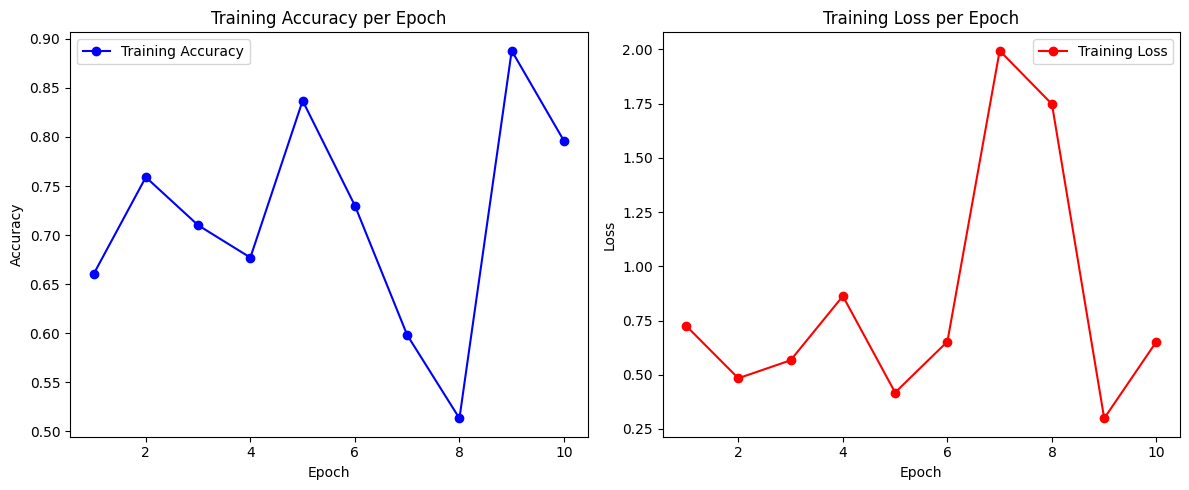

In [36]:
val_accuracies = [0.6600, 0.7590, 0.7100, 0.6770, 0.8370, 0.7300, 0.5980, 0.5130, 0.8880, 0.7960]
val_losses     = [0.7261, 0.4840, 0.5668, 0.8628, 0.4182, 0.6530, 1.9943, 1.7483, 0.2991, 0.6534]

import matplotlib.pyplot as plt

epochs = range(1, 11)

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracies, 'b-o', label='Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(False)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_losses, 'r-o', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
# Step 6: Set up data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_generator = train_datagen.flow_from_directory(
    '/Users/jaeeponde/tai_final_project/rvf_subset_5000/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False

)

Found 1000 images belonging to 2 classes.


/Users/jaeeponde/anaconda3/envs/kcdha/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step
Classification Report:

              precision    recall  f1-score   support

        fake       0.83      0.89      0.86       500
        real       0.88      0.82      0.85       500

    accuracy                           0.85      1000
   macro avg       0.86      0.85      0.85      1000
weighted avg       0.86      0.85      0.85      1000



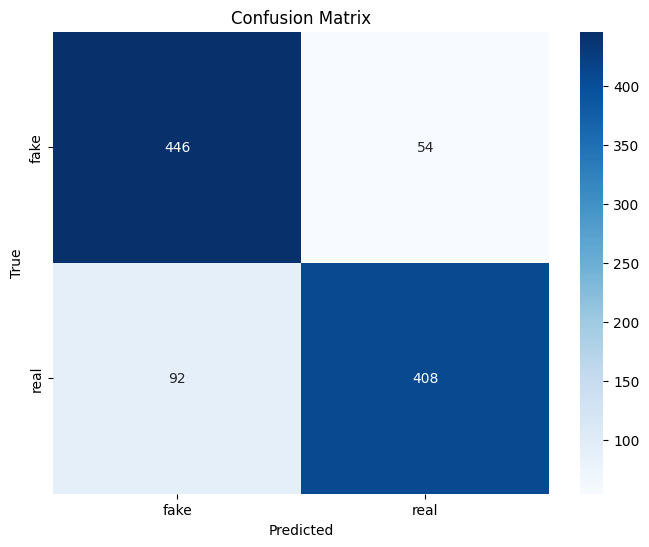

ROC AUC Score: 0.9396


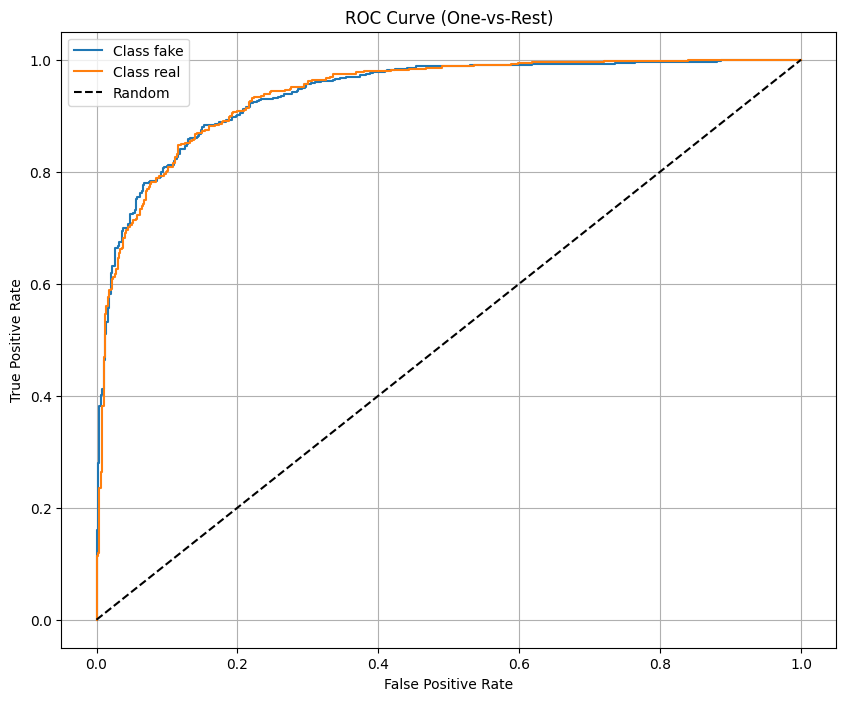

In [38]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Load model
model = tf.keras.models.load_model('/Users/jaeeponde/tai_final_project/inceptionv3_adv_trained.h5')

# Get true labels and predicted probabilities
test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# AUC-ROC (for multi-class - One-vs-Rest)
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))
roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, multi_class='ovr')

print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step
Classification Report:

              precision    recall  f1-score   support

        fake       0.96      0.76      0.85       500
        real       0.80      0.97      0.88       500

    accuracy                           0.87      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.87      0.87      1000



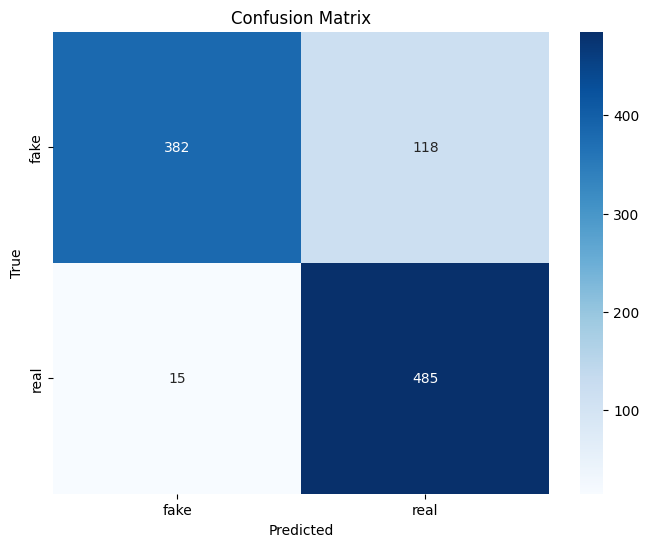

ROC AUC Score: 0.9683


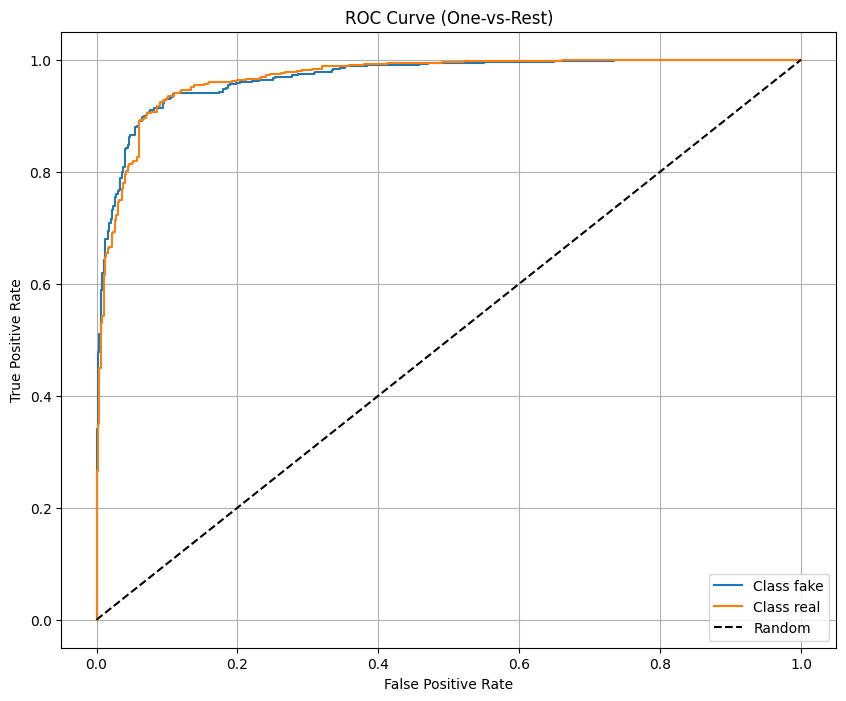

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Load model
model = tf.keras.models.load_model('/Users/jaeeponde/tai_final_project/fine_tuned_model.h5')

# Get true labels and predicted probabilities
test_generator.reset()
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# AUC-ROC (for multi-class - One-vs-Rest)
y_true_onehot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_labels))
roc_auc = roc_auc_score(y_true_onehot, y_pred_prob, multi_class='ovr')

print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]}')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()
